<a href="https://colab.research.google.com/github/ch00226855/CMP414765Spring2021/blob/main/Week05_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5
# Simple Linear Regression and the Normal Equation

So far we have treated machine learning models and their training algorithms mostly like black boxes. Starting from Chapter 4, we will look into the mechanism of several popular machine learning models, analyze them mathematically and learn how to implement the methods from scratch. Let's start with the linear regression model.

**Reading**: Textbook, Chapter 4

## I. Simple Linear regression: Sales Prediction

To put things into context, let's look at a dataset that contains the sales revenue and the advertising budgets of a company in 200 different markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://www.statlearning.com/s/Advertising.csv"
advertising = pd.read_csv(url, index_col=0)
advertising.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
advertising.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [4]:
advertising.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


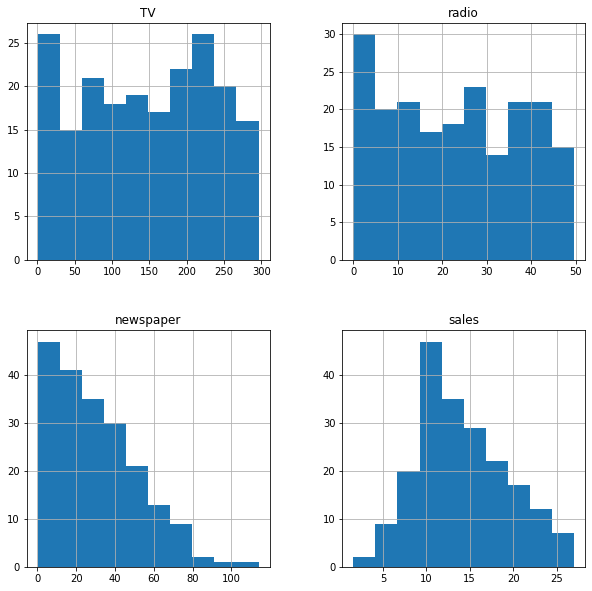

In [5]:
fig = advertising.hist(figsize=(10, 10))

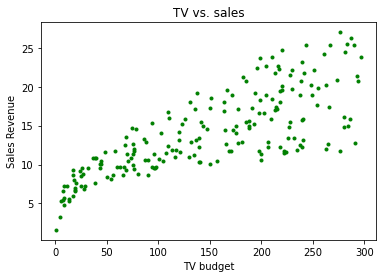

In [6]:
# plot TV vs. sales
plt.plot(advertising['TV'], advertising['sales'], 'g.')
plt.title("TV vs. sales")
plt.xlabel("TV budget")
plt.ylabel("Sales Revenue")
plt.savefig("TVvsSales.png")
plt.show() # this is needed in other Python environments

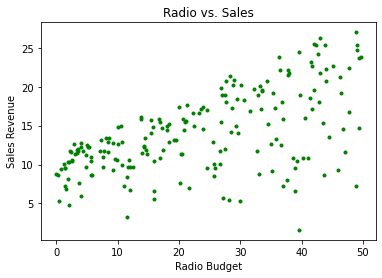

In [11]:
# Exercise:
# plot radio vs. sales

plt.plot(advertising['radio'], advertising['sales'], 'g.')
plt.title("Radio vs. Sales")
plt.xlabel("Radio Budget")
plt.ylabel("Sales Revenue")
plt.savefig("RadiovsSales.png")

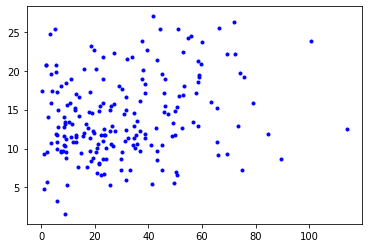

In [12]:
# Exercise:
# plot newspaper vs. sales

plt.plot(advertising['newspaper'], advertising['sales'], 'b.')

### Correlation Coefficient: Numerical Measure of Correlations
The **correlation coefficient** is a numerical measurement of **linear correlation** between two variables.
- The value of correlation coefficient always lies in [-1, 1].
- If there is a strong positive correlation, then the coefficient is close to 1.
- If there is a strong negative correlation, then the coefficient is close to -1.
- If there is a very weak correlation, then the coefficient is close to 0.
- However, a near-zero coeffient may be caused by non-linear correlations.
![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

In [13]:
# Calculate pair-wise correlation coefficients
advertising.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


For simplicity, we will only use `TV` as a predictor of `sales`.

In [14]:
data = advertising.loc[:, ['TV', 'sales']]
data.head()

,TV,sales
1,230.1,22.1
2,44.5,10.4
3,17.2,9.3
4,151.5,18.5
5,180.8,12.9


## Simple Linear Regression: Model Representation

In order to describe the model mathematically, we need to introduce a few notations:
- The input feature `TV` is represented as variable $X$.
- The output/response feature `sales` is represented as variable $Y$.
- Each instance of data is represented as $(x_i, y_i)$, where $i$ is the row index, $x_i$ is the value corresponding to $X$, and $y_i$ is the value corresponding to $Y$. For example, $(x_1, y_1) = (230.1, 22.1)$.

The **simple linear regression** model assumes that the relationship between $X$ and $Y$ is
$$Y \approx f(X) = \beta_0 + \beta_1 X.$$

- $\beta_0$ and $\beta_1$ are called **model parameters**. For simple linear regression, the relationship is characterized as a straight line with slope $\beta_1$ and y-intercept $\beta_0$.


In [15]:
# Train a linear regression model using sklearn
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(data[['TV']], data[['sales']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
# The coef_ and intercept_ attributes contain parameter values
print(model_lr.coef_)
print(model_lr.intercept_)

[[0.04753664]]
[7.03259355]


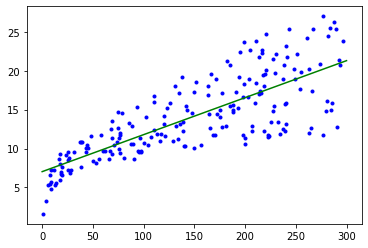

In [17]:
# Plot the data points and the optimal regression line.
m = model_lr.coef_[0, 0]   # slope
b = model_lr.intercept_[0] # y-intercept

plt.plot(data['TV'], data['sales'], 'b.')
x_coordinates = np.array([0,300])
y_coordinates = x_coordinates * m + b
plt.plot(x_coordinates, y_coordinates, 'g-')

## Train A Simple Linear Regression Model

- For a given set of model parameters, we need a **cost function** (in some occasions also called **loss function**) that measures how well a given line fits the data.
- We also need a **training algorithm** that finds values of parameters so that the line fits the data well (usually "fitting the data well" means "minimizing the cost").

For linear regression:
- Cost function: 
    - Mean squared error (MSE)
    - Mean absolute error (MAE)
    - Other variants
- Training algorithm: 
    - Normal equation
    - Gradient descent

## Simple Linear Regression: Cost Function
A common choice of cost function is the **mean squared error (MSE) function**. It is defined as
$$\begin{align}
MSE(\beta_0, \beta_1) =& 
\frac{1}{N}\sum_{i=1}^N (y_i - f(x_i))^2 \\
=& \frac{1}{N}\sum_{i=1}^N\big(y_i - \beta_0 - \beta_1x_i\big)^2.
\end{align}$$

To better understand the MSE function, let's calculate the value $MSE(7.03, 0.04)$.

In [ ]:
# Example:
# Calculate the squared error of the model on the first record.

beta0 = 7.03
beta1 = 0.04

x1 = data.loc[1, 'TV'] # 230.1
y1 = data.loc[1, 'sales'] #22.1
print("x1, y1:", x1, y1)

# Calculate f(x1) = beta0 + beta1 * x1


# Calculate the squared error (y1 - f(x1)) ** 2


print("Squared error:", squared_error)

In [ ]:
# Example:
# Calculate the squared error of the model on an arbitrary record.

beta0 = 7.03
beta1 = 0.04

i = ??  # index of the record
xi = ???
yi = ???
print("x1, y1:", x1, y1)

# Calculate f(xi)


# Calculate the squared error (yi - f(xi)) ** 2


print("Squared error:", squared_error)

In [ ]:
# Write a function that produces the squared error given beta0, beta1, data, and i
def get_squared_error(beta0, beta1, data, i):

    pass

In [ ]:
# Create a list that contains value of (y_1 - f(x_1))^2 for i=1,...,200.
list_errors = []
for ind in data.index:
    # call function `get_sqaured_error` with ind

    # append squared error to `list_errors`

    pass
    
print(list_errors)

In [ ]:
# Create list_errors using list comprehension



In [ ]:
# Calculate the MSE

print("MSE:", MSE)

In [ ]:
# Write a function MSE(beta0, beta1, data) that returns the value of MSE with given beta0 and beta1.
def get_MSE(beta0, beta1, data):

    pass

Now, use function `get_MSE` to obtain the MSE for the following two sets of parameter values
- Case 1: $\beta_0 = 7.03, \beta_1 = 0.04$
- Case 2: $\beta_0 = 5, \beta_1 = 1$

Which one fits the data better?

Now that we have obtained the cost function, our next goal is to find the parameter values that minimizes the cost value.

# Simple Linear Regression: Training Algorithm
To find the value of $\beta_0, \beta_1$ that minimizes the MSE cost function, there is a formula called the **normal equation** that gives the result directly:

$$\begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix} = (\textbf{X}^T\cdot\textbf{X})^{-1}\cdot\textbf{X}^T\cdot\textbf{y}.$$

- $\textbf{X}$ is the matrix formed as 
$$\textbf{X} = \begin{pmatrix} 
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N \\
\end{pmatrix}.$$
- $\textbf{X}$ represents the **matrix transpose** of $\textbf{X}$.
- $\cdot$ represents **matrix multiplication**.
- $^{-1}$ represents **matrix inverse**.
- $\textbf{y}$ is the vector of target values
$$\textbf{y} = \begin{pmatrix} 
y_1 \\
y_2 \\
\vdots \\
y_N \\
\end{pmatrix}.$$

Let's apply the normal equation and find the best parameter values.

In [ ]:
# Construct X and y as numpy arrays
X = np.hstack([np.ones([len(data), 1]), data[['TV']].values])
# print(X)
y = data[['sales']].values
# print(y)

beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(beta)

In [ ]:
get_MSE(7.03, 0.047, data)

In [ ]:
# Plot the data points and the optimal regression line.
plt.plot(data['TV'], data['sales'], 'b.')
x_coordinates = np.array([0,300])
y_coordinates = x_coordinates * 0.047 + 7.03
plt.plot(x_coordinates, y_coordinates, 'g-')